In [143]:
import numpy as np
import os
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
from astropy.coordinates import SkyCoord 
import healpy
import astropy.units as u
import pandas as pd
import matplotlib
import pyccl
from scipy import stats

os.environ['CLMM_MODELING_BACKEND'] = 'ccl' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)

import clmm
from clmm.support.sampler import fitters

from importlib import reload  

import sys
sys.path.append('../../')
from magnification_library import *

In [144]:
clmm.__version__

'1.0.0'

In [145]:
matplotlib.rcParams.update({'font.size': 18})

In [146]:
#define cosmology

#astropy object
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

In [147]:
path_file = '../../../'

In [148]:
key = 'LBGp'

## **Profiles measured with TreeCorr**

In [214]:
quant = np.load(path_file + "output_data/binned_correleation_fct_Mpc_"+key+".npy", allow_pickle=True)
quant_NK = np.load(path_file + "output_data/binned_correleation_fct_NK_Mpc_"+key+".npy", allow_pickle=True)

## **Measuring profiles with astropy and CLMM**


## Open data

In [150]:

gal_cat_raw =  pd.read_hdf(path_file+'input_data/cat_'+key+'.h5', key=key)
dat = np.load(path_file+"input_data/source_sample_properties.npy", allow_pickle=True)
mag_cut, alpha_cut, mag_null, gal_dens, zmean = dat[np.where(dat[:,0]==key)][0][1:]

print (alpha_cut)
mag_cut

3.320964657712193


25.495

In [151]:
selection_source = (gal_cat_raw['ra']>50) & (gal_cat_raw['ra']<73.1) & (gal_cat_raw['dec']<-27.) & (gal_cat_raw['dec']>-45.)
selection = selection_source & (gal_cat_raw['mag_i_lsst']<mag_cut) & (gal_cat_raw['redshift']>1.5)

gal_cat = gal_cat_raw[selection]

In [152]:
[z_cl, mass_cl, n_halo] = np.load(path_file + "output_data/halo_bin_properties.npy", allow_pickle=True)

In [153]:
np.sum(n_halo)

21982.0

## Open halo catalog and define binning

In [154]:
halo_cat =  pd.read_hdf(path_file + 'input_data/cat_halos.h5')
ra_min  = 50 
ra_max  = 73.1
dec_min = -45
dec_max = -27
selection_halo = ( halo_cat['ra']>ra_min) & ( halo_cat['ra']<ra_max) & ( halo_cat['dec']<dec_max) & ( halo_cat['dec']>dec_min)

In [155]:
zbins = np.array(([0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1.0], [1.0, 1.2]))

In [156]:
mbins = np.array(([20,30],[30,45],[45,70],[70,120],[120,220]))*(1e14/45)

In [157]:
bin_sel = np.zeros((zbins.shape[0], mbins.shape[0]), dtype=object)
for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        bin_sel[i,j] = selection_halo & (halo_cat['redshift']> zbins[i][0]) & (halo_cat['redshift']< zbins[i][1]) & (halo_cat['halo_mass']> mbins[j][0]) & (halo_cat['halo_mass']< mbins[j][1])

In [158]:
wide_selection = selection_halo &  (halo_cat['redshift']> zbins.min()) & (halo_cat['redshift']< zbins.max()) & (halo_cat['halo_mass']> mbins.min()) & (halo_cat['halo_mass']< mbins.max())

In [159]:
np.sum(wide_selection)

21982

## Select source galaxies around clusters

In [160]:
source = SkyCoord(gal_cat.ra.values*u.deg, gal_cat.dec.values*u.deg)

In [161]:
match = np.zeros(z_cl.shape, dtype=object)
match_rand = np.zeros(z_cl.shape, dtype=object)

In [162]:
rmin_Mpc, rmax_Mpc = 0.1*u.Mpc, 7*u.Mpc
#rmin_Mpc, rmax_Mpc = 0.1*u.Mpc, 3.5*u.Mpc

bin_dict={'min_sep':0.1, 'max_sep':20, 'sep_units':'arcmin','bin_type':'Log','nbins':10, 'var_method':'shot'}



for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        conv = cosmo.arcsec_per_kpc_proper(z_cl[i,j]).to(u.arcmin/u.Mpc)
        sep_max = conv * rmax_Mpc
        lens = SkyCoord(halo_cat[bin_sel[i,j]].ra.values*u.deg, halo_cat[bin_sel[i,j]].dec.values*u.deg)
        match[i,j] = source.search_around_sky(lens, sep_max)
        
        rand_ra = np.random.uniform(ra_min*u.deg.to(u.rad), ra_max*u.deg.to(u.rad), sum(bin_sel[i,j]))
        rand_dec = np.arcsin(np.random.uniform(np.sin(dec_min*u.deg.to(u.rad)), np.sin(dec_max*u.deg.to(u.rad)), sum(bin_sel[i,j]) ))

        lens_rand = SkyCoord(rand_ra*u.rad.to(u.deg)*u.deg, rand_dec*u.rad.to(u.deg)*u.deg)
        match_rand[i,j] = source.search_around_sky(lens_rand, sep_max)


## Magnification stacked profiles

In [163]:
#bins = clmm.make_bins(bin_dict['min_sep'], bin_dict['max_sep'], nbins=bin_dict['nbins'], method='evenlog10width')

mu_profiles = np.zeros(z_cl.shape, dtype=object)
mu_profiles_rand = np.zeros(z_cl.shape, dtype=object)


for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        conv = cosmo.kpc_proper_per_arcmin(z_cl[i,j]).to(u.Mpc/u.arcmin)
        bins = clmm.make_bins(rmin_Mpc.value, rmax_Mpc.value, nbins=bin_dict['nbins'], method='evenlog10width')
        mu_profiles[i,j] = clmm.compute_radial_averages((conv * match[i,j][2].to(u.arcmin)).value, gal_cat['magnification'].iloc[match[i,j][1]], bins, error_model='std/sqrt_n')
        mu_profiles_rand[i,j] = clmm.compute_radial_averages((conv * match_rand[i,j][2].to(u.arcmin)).value, gal_cat['magnification'].iloc[match_rand[i,j][1]], bins, error_model='std/sqrt_n')

/pbs/throng/lsst/users/mricci/desc/my_clean_env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


## **Magnification profiles prediction**


In [164]:
def Mpc_to_arcmin(x_Mpc, z, cosmo=cosmo):
    return x_Mpc * cosmo.arcsec_per_kpc_proper(z).to(u.arcmin/u.Mpc).value

def arcmin_to_Mpc(x_arc, z, cosmo=cosmo):
    return x_arc * cosmo.kpc_proper_per_arcmin(z).to(u.Mpc/u.arcmin).value 

In [165]:
def magnification_biais_model(rproj, mass_lens, z_lens, alpha, z_source, cosmo_clmm, delta_so='200', massdef='mean', Mc_relation ='Diemer15'):
    
    conc = get_halo_concentration(mass_lens, z_lens, cosmo_clmm.be_cosmo, Mc_relation, mdef[0], delta_so )
    magnification = np.zeros(len(rproj))
    for k in range(len(rproj)):

        magnification[k] = np.nanmean(clmm.theory.compute_magnification(rproj[k], mdelta=mass_lens, cdelta=conc, 
                                        z_cluster=z_lens, z_source=z_source, cosmo=cosmo_clmm, 
                                        delta_mdef=delta_so, 
                                        massdef = massdef,
                                        halo_profile_model='NFW', 
                                        z_src_model='single_plane'))

        
    model = mu_bias(magnification, alpha) - 1. 
    
    return model, magnification
    

In [166]:
def get_halo_concentration(mass_lens, z_lens, cosmo_ccl, relation="Diemer15", mdef="matter", delta_so=200):
    mdef = pyccl.halos.massdef.MassDef(delta_so, mdef, c_m_relation=relation)
    concdef = pyccl.halos.concentration.concentration_from_name(relation)()
    conc = concdef.get_concentration(cosmo=cosmo_clmm.be_cosmo, M=mass_lens, a=cosmo_clmm.get_a_from_z(z=z_lens), mdef_other=mdef)
    return conc 

Text(0, 0.5, 'pdf')

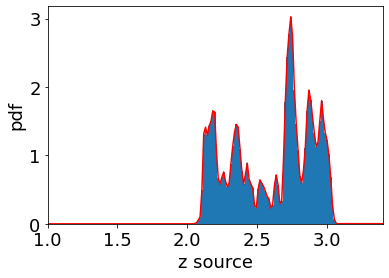

In [167]:
hist = plt.hist(gal_cat['redshift'][selection], bins=100, range=[1.8,3.1], density=True, stacked=True);
pdf_zsource = zpdf_from_hist(hist, zmin=0, zmax=10)
plt.plot(pdf_zsource.x, pdf_zsource.y, 'r')
plt.xlim(1,3.4)

plt.xlabel('z source')
plt.ylabel('pdf')

In [168]:
zint = np.linspace(0, 3.5, 1000)
zrand = np.random.choice(zint, 1000, p=pdf_zsource(zint)/np.sum(pdf_zsource(zint)))

In [169]:
Mc_relation = "Diemer15"
mdef = ["matter", "mean"] #differet terminology for ccl and clmm
delta_so=200


#model with the full redshift distribution
rp_Mpc = np.logspace(-2, 3, 100)

model_mbias = np.zeros((rp_Mpc.size, len(z_cl), len(mass_cl)))
model_magnification = np.zeros((rp_Mpc.size, len(z_cl), len(mass_cl)))

for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        #rp_Mpc = arcmin_to_Mpc(rp, z_cl[i,j], cosmo)
        models = magnification_biais_model(rp_Mpc, mass_cl[i,j], z_cl[i,j], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)
        model_mbias[:,i,j] = models[0]
        model_magnification[:,i,j] = models[1]

../../magnification_library.py:92: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


## **Plotting figures**


## Example for one mass/z bin


Text(0, 0.5, '$\\mu$')

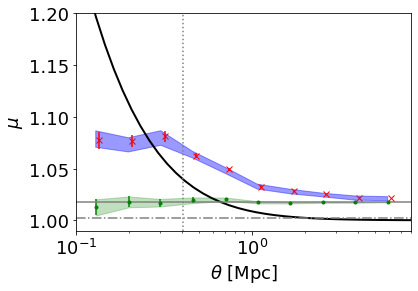

In [215]:
i,j = 3,0

plt.fill_between(quant_NK[i,j][0], y1= quant_NK[i,j][1] - np.sqrt(np.diag(quant_NK[i,j][2])),\
                 y2 =  quant_NK[i,j][1] + np.sqrt(np.diag(quant_NK[i,j][2])),color = 'blue', alpha=0.4, label='TreeCorr')

plt.errorbar(mu_profiles[i,j][0]*1.05, mu_profiles[i,j][1], yerr= mu_profiles[i,j][2], fmt='rx', label='astropy & CLMM')

plt.errorbar(mu_profiles_rand[i,j][0], mu_profiles_rand[i,j][1], yerr= mu_profiles_rand[i,j][2], fmt='g.', label='null test')
plt.fill_between(mu_profiles_rand[i,j][0], y1 = mu_profiles_rand[i,j][1] - mu_profiles_rand[i,j][2], \
                 y2 = mu_profiles_rand[i,j][1] + mu_profiles_rand[i,j][2], color='green', alpha=0.25)

plt.plot(rp_Mpc, model_magnification[:,i,j],'k', lw=2,  label='model (1 halo term)')

plt.axhline(np.mean(gal_cat['magnification']),color='grey', label='mean $\mu$')
plt.axhline(np.median(gal_cat['magnification']),color='grey', ls='-.', label='median $\mu$')

plt.axvline(cosmo.kpc_proper_per_arcmin(z_cl[i,j]).to(u.Mpc/u.arcmin).value*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey', label ='healpix resol.')

plt.xscale('log')
plt.xlim(0.1,8)
plt.ylim(0.99,1.2)

plt.xlabel('$\\theta$ [Mpc]')
plt.ylabel('$\mu$')

#plt.legend(fontsize='small', ncol=1)


#### The errors are computed differently : 
- error measurements for TreeCorr => Var(rbin) = Var(all galaxies)/n_gal_rbin 
- error measurements for TreeCorr => Var(rbin) = Var(gal rbin)/n_gal_rbin

#### The profiles are offset by the mean magnification value of the sources, they do not tend to 1 at large radii (similar to profiles at random position shown in green)

## Magnification profiles for cluster in mass/z bins

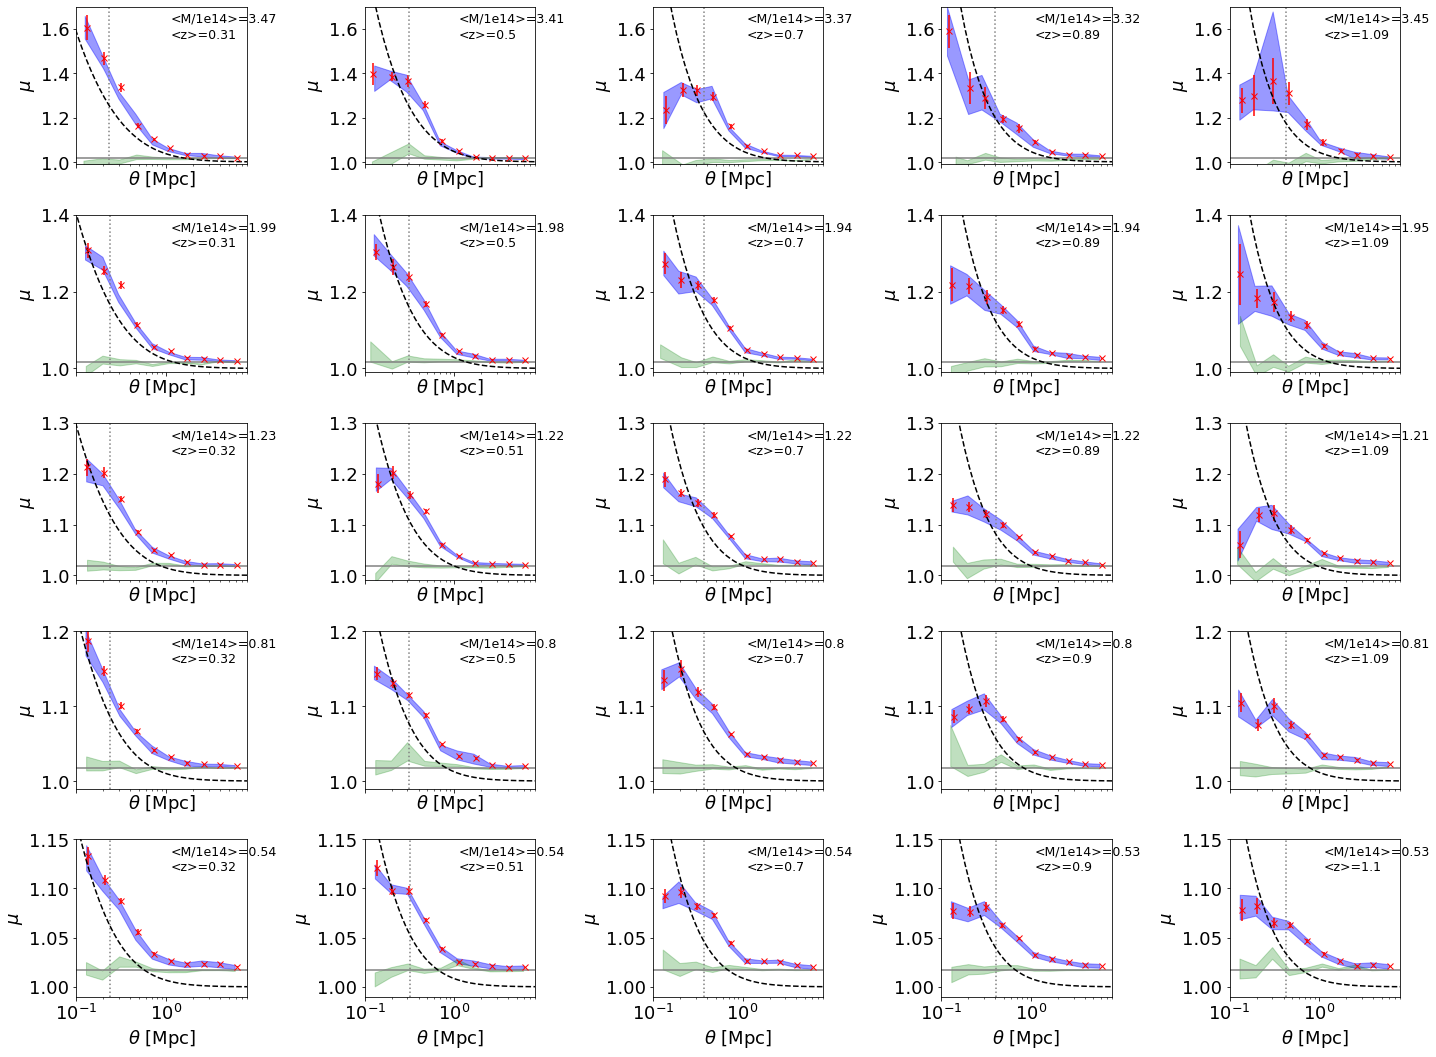

In [216]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)


for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        ax = axes[5-1-k,h]
        
        ax.fill_between(quant_NK[i,j][0], y1= quant_NK[i,j][1] - np.sqrt(np.diag(quant_NK[i,j][2])),\
                 y2 =  quant_NK[i,j][1]  + np.sqrt(np.diag(quant_NK[i,j][2])),color = 'blue', alpha=0.4)

        ax.errorbar(mu_profiles[i,j][0]*1.05, mu_profiles[i,j][1], yerr=mu_profiles[i,j][2], fmt='rx')
        ax.fill_between(mu_profiles_rand[i,j][0], y1 = mu_profiles_rand[i,j][1] - mu_profiles_rand[i,j][2], \
                 y2 = mu_profiles_rand[i,j][1] + mu_profiles_rand[i,j][2], color='green', alpha=0.25)

        ax.axvline(cosmo.kpc_proper_per_arcmin(z_cl[i,j]).to(u.Mpc/u.arcmin).value*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey', label ='healpix resol.')

        ax.axhline(np.mean(gal_cat['magnification']),color='grey', label='mean $\mu$')
        
        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
          
        ax.set_xlabel('$\\theta$ [Mpc]')
        ax.set_ylabel('$\mu$')

        ax.plot(rp_Mpc, model_magnification[:,i,j],'k--')
        
plt.tight_layout()


axes[0,0].set_xscale('log')
axes[0,0].set_xlim(0.1,8.)

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(0.99,1.15)
    axes[3,i].set_ylim(0.99,1.2)
    axes[2,i].set_ylim(0.99,1.3)
    axes[1,i].set_ylim(0.99,1.4)
    axes[0,i].set_ylim(0.99,1.7)

## Magnification profiles for cluster in mass/z bins, corrected from the mean magnification excess

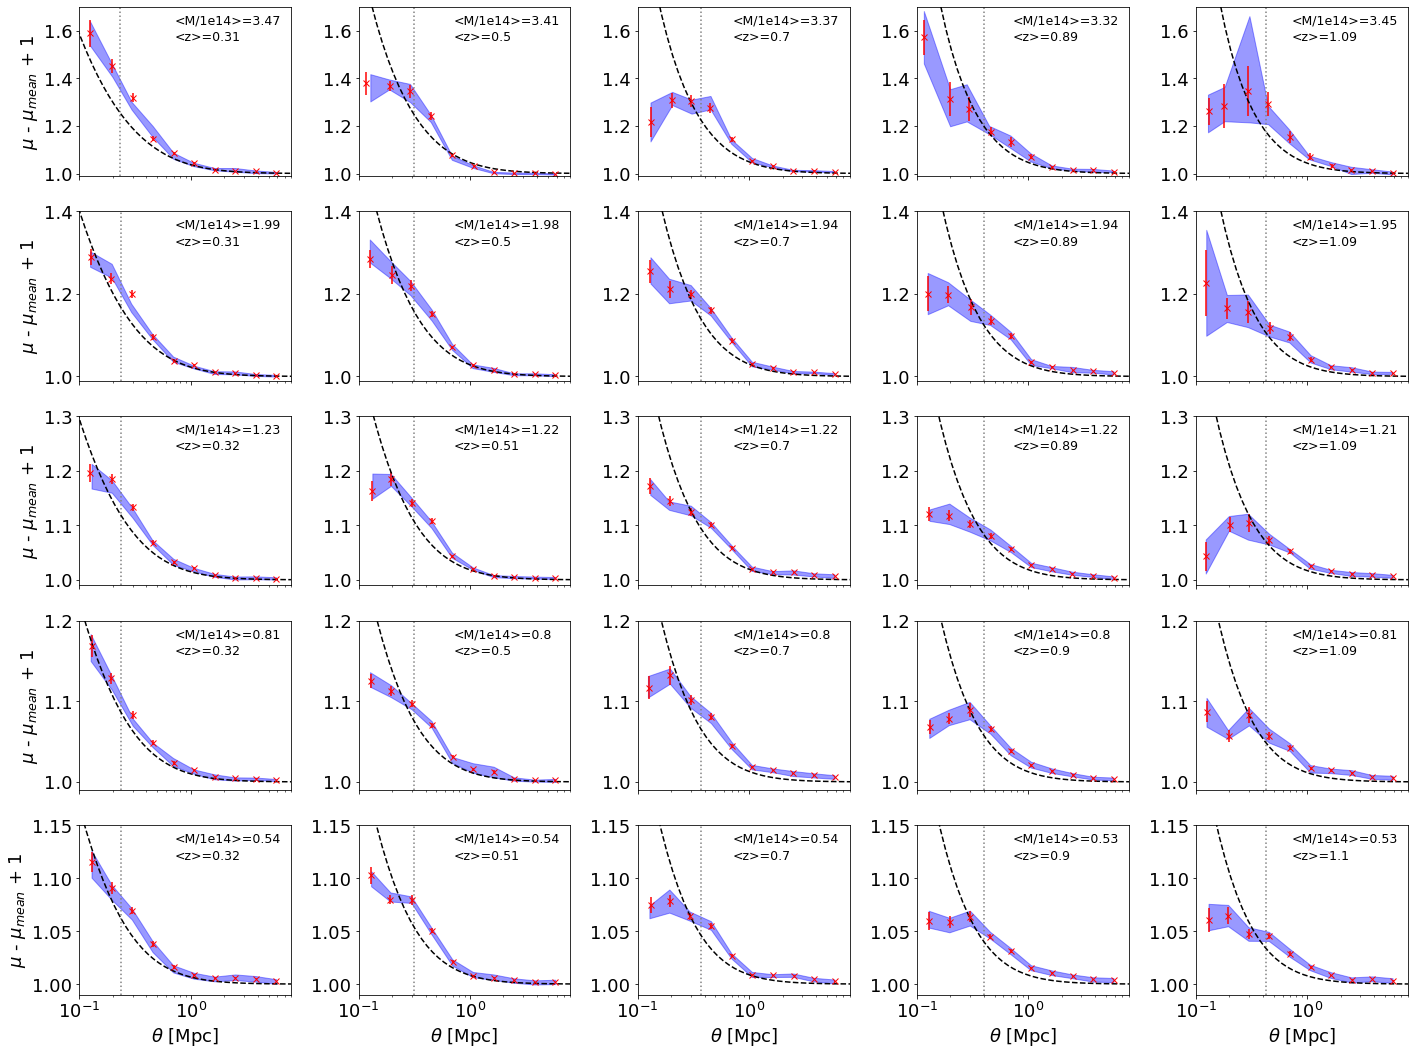

In [217]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)

corr = np.mean(gal_cat['magnification']) - 1

for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        ax = axes[5-1-k,h]
        
        ax.fill_between(quant_NK[i,j][0], y1= quant_NK[i,j][1] - corr - np.sqrt(np.diag(quant_NK[i,j][2])),\
                 y2 =  quant_NK[i,j][1] - corr + np.sqrt(np.diag(quant_NK[i,j][2])),color = 'blue', alpha=0.4)

        #ax.errorbar(quant_NK[i,j][0],quant_NK[i,j][1] ,yerr=np.sqrt(np.diag(quant_NK[i,j][2])),fmt='b.-')
        ax.errorbar(mu_profiles[i,j][0], mu_profiles[i,j][1] - corr, yerr=mu_profiles[i,j][2], fmt='rx')


        ax.axvline(cosmo.kpc_proper_per_arcmin(z_cl[i,j]).to(u.Mpc/u.arcmin).value * healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey', label ='healpix resol.')

        ax.text(0.45, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.45, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
          
        ax.plot(rp_Mpc, model_magnification[:,i,j],'k--')
        

[axes[4,j].set_xlabel('$\\theta$ [Mpc]') for j in range(5)]
[axes[i,0].set_ylabel('$\mu$ - $\mu_{mean}$ + 1') for i in range(5)]

axes[0,0].set_xscale('log')
axes[0,0].set_xlim(0.1,8)

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(0.99,1.15)
    axes[3,i].set_ylim(0.99,1.2)
    axes[2,i].set_ylim(0.99,1.3)
    axes[1,i].set_ylim(0.99,1.4)
    axes[0,i].set_ylim(0.99,1.7)
                       
plt.tight_layout()

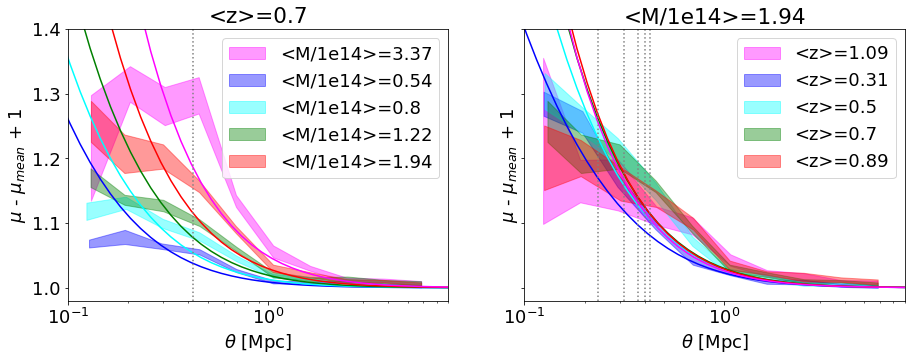

In [218]:
fig, axes = plt.subplots(1,2, figsize=[15,5], sharex=True, sharey=True)

colors = ['blue', 'cyan', 'green', 'red','magenta']


i = 2
axes[0].set_title("<z>="+str(round(z_cl[i,2],2)))
[axes[0].fill_between(quant_NK[i,j][0], y1= quant_NK[i,j][1] - corr - np.sqrt(np.diag(quant_NK[i,j][2])),\
                      y2 =  quant_NK[i,j][1] - corr + np.sqrt(np.diag(quant_NK[i,j][2])),color = colors[j], alpha=0.4, label = "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2))) for j in (4, 0,1,2,3)]

[axes[0].plot(rp_Mpc, model_magnification[:,i,j],'-', color=colors[j])  for j in (0,1,2,3, 4)]

j = 3
axes[1].set_title( "<M/1e14>="+str(round(mass_cl[2,j]/1e14,2))) 
[axes[1].fill_between(quant_NK[i,j][0], y1= quant_NK[i,j][1] - corr - np.sqrt(np.diag(quant_NK[i,j][2])),\
                      y2 =  quant_NK[i,j][1] - corr + np.sqrt(np.diag(quant_NK[i,j][2])),color =  colors[i], alpha=0.4, label = "<z>="+str(round(z_cl[i,j],2))) for i in (4, 0,1,2,3)]

[axes[1].plot(rp_Mpc, model_magnification[:,i,j],'-', color=colors[i])  for i in (0,1,2,3, 4)]

axes[0].axvline(cosmo.kpc_proper_per_arcmin(z_cl[i_f,j_f]).to(u.Mpc/u.arcmin).value*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey')
[axes[1].axvline(cosmo.kpc_proper_per_arcmin(z_cl[i,j_f]).to(u.Mpc/u.arcmin).value*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey') for i in (0,1,2,3,4)]



axes[0].set_ylim(0.98, 1.4)

axes[0].set_xscale('log')
axes[0].set_xlim(0.1, 8)

axes[0].set_xlabel('$\\theta$ [Mpc]')
axes[1].set_xlabel('$\\theta$ [Mpc]')

axes[0].set_ylabel('$\mu$ - $\mu_{mean}$ + 1')
axes[1].set_ylabel('$\mu$ - $\mu_{mean}$ + 1')

axes[0].legend()
axes[1].legend()

## Attempt to fit the mass

In [219]:
def predict_function(radius_Mpc, logM, z_cl):
    mass_guess = 10**logM
    return magnification_biais_model(radius_Mpc, mass_guess, z_cl, alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)[1]

In [239]:
def fit_mass(predict_function, data_for_fit, z):
    popt, pcov = fitters['curve_fit'](lambda radius_Mpc, logM: predict_function(radius_Mpc, logM, z),
        data_for_fit[0], 
        data_for_fit[1]-corr, 
        np.sqrt(np.diag(data_for_fit[2])), bounds=[10.,17.], absolute_sigma=True, p0=(13.))
    logm, logm_err = popt[0], np.sqrt(pcov[0][0])
    return {'logm':logm, 'logm_err':logm_err,
            'm': 10**logm, 'm_err': (10**logm)*logm_err*np.log(10)}

In [240]:
fit_mass_magnification = np.zeros(z_cl.shape, dtype=object)

mass_eval = np.zeros((z_cl.shape))
mass_min = np.zeros((z_cl.shape))
mass_max = np.zeros((z_cl.shape))

for i in range(5):
    for j in range(5):
        fit_mass_magnification[i,j] = fit_mass(predict_function, quant_NK[i,j], z_cl[i,j])
        
        mass_eval[i,j] = fit_mass_magnification[i,j]['m']
        mass_min[i,j] = fit_mass_magnification[i,j]['m'] - fit_mass_magnification[i,j]['m_err']
        mass_max[i,j] = fit_mass_magnification[i,j]['m'] + fit_mass_magnification[i,j]['m_err']

../../magnification_library.py:92: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


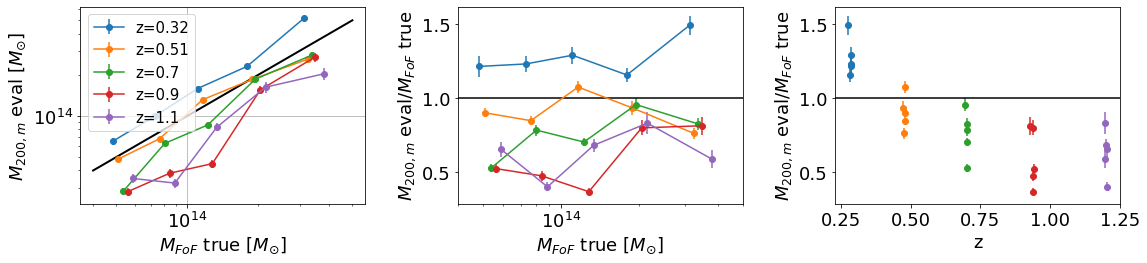

In [241]:

fig, ax = plt.subplots(1, 3, figsize=(16,4))

ax[0].errorbar(mass_cl[0,:]*0.90, mass_eval[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:]),fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[0].errorbar(mass_cl[1,:]*0.95, mass_eval[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:]),fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[0].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:]),fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[0].errorbar(mass_cl[3,:]*1.05, mass_eval[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:]),fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[0].errorbar(mass_cl[4,:]*1.10, mass_eval[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:]),fmt='-o', label ="z="+str(round(z_cl[4,0],2)))


ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].plot((4e13, 5e14),(4e13,5e14), color='black', lw=2)
ax[0].legend(fontsize='small')
ax[0].set_xlabel("$M_{FoF}$ true [$M_{\odot}$]")
ax[0].set_ylabel("$M_{200,m}$ eval [$M_{\odot}$]")

ax[0].grid()

ax[1].errorbar(mass_cl[0,:]*0.90, mass_eval[0,:]/mass_cl[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:])/mass_cl[0,:],fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[1].errorbar(mass_cl[1,:]*0.95, mass_eval[1,:]/mass_cl[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:])/mass_cl[1,:],fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[1].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:]/mass_cl[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:])/mass_cl[2,:],fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[1].errorbar(mass_cl[3,:]*1.05, mass_eval[3,:]/mass_cl[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:])/mass_cl[3,:],fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[1].errorbar(mass_cl[4,:]*1.10, mass_eval[4,:]/mass_cl[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:])/mass_cl[4,:],fmt='-o', label ="z="+str(round(z_cl[4,0],2)))


ax[1].set_xscale('log')
ax[1].set_xlim(4e13, 5e14)
ax[1].axhline(1, color='black')
#ax[1].legend()
ax[1].set_xlabel("$M_{FoF}$ true [$M_{\odot}$]")
ax[1].set_ylabel("$M_{200,m}$ eval/$M_{FoF}$ true")


ax[2].errorbar(z_cl[0,:]*0.90, mass_eval[0,:]/mass_cl[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:])/mass_cl[0,:],fmt='o', label ="z="+str(round(z_cl[0,0],2)))
ax[2].errorbar(z_cl[1,:]*0.95, mass_eval[1,:]/mass_cl[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:])/mass_cl[1,:],fmt='o', label ="z="+str(round(z_cl[1,0],2)))
ax[2].errorbar(z_cl[2,:]*1.00, mass_eval[2,:]/mass_cl[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:])/mass_cl[2,:],fmt='o', label ="z="+str(round(z_cl[2,0],2)))
ax[2].errorbar(z_cl[3,:]*1.05, mass_eval[3,:]/mass_cl[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:])/mass_cl[3,:],fmt='o', label ="z="+str(round(z_cl[3,0],2)))
ax[2].errorbar(z_cl[4,:]*1.10, mass_eval[4,:]/mass_cl[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:])/mass_cl[4,:],fmt='o', label ="z="+str(round(z_cl[4,0],2)))

ax[2].axhline(1, color='black')
ax[2].set_ylabel("$M_{200,m}$ eval/$M_{FoF}$ true")
ax[2].set_xlabel('z')

#ax[2].plot(mass_cl[0,:]*0.90, mass_eval[0,:]/(0.5*(mass_max[0,:] - mass_min[0,:])),'-o', label ="z="+str(round(z_cl[0,0],2)))
#ax[2].plot(mass_cl[1,:]*0.95, mass_eval[1,:]/(0.5*(mass_max[1,:] - mass_min[1,:])),'-o', label ="z="+str(round(z_cl[1,0],2)))
#ax[2].plot(mass_cl[2,:]*1.00, mass_eval[2,:]/(0.5*(mass_max[2,:] - mass_min[2,:])),'-o', label ="z="+str(round(z_cl[2,0],2)))
#ax[2].plot(mass_cl[3,:]*1.05, mass_eval[3,:]/(0.5*(mass_max[3,:] - mass_min[3,:])),'-o', label ="z="+str(round(z_cl[3,0],2)))
#ax[2].plot(mass_cl[4,:]*1.10, mass_eval[4,:]/(0.5*(mass_max[4,:] - mass_min[4,:])),'-o', label ="z="+str(round(z_cl[4,0],2)))

#ax[2].set_xscale('log')
#ax[2].legend()
#ax[2].set_ylabel("SNR")
#ax[2].set_xlabel("mass eval")
#ax[2].grid()

plt.tight_layout()

In [242]:
model_for_fitted_mass = np.zeros(z_cl.shape,dtype=object)
model_for_fitted_mass_min = np.zeros(z_cl.shape,dtype=object)
model_for_fitted_mass_max = np.zeros(z_cl.shape,dtype=object)

for i in range(z_cl.shape[0]):
    for j in range(z_cl.shape[1]):
        model_for_fitted_mass[i,j] = magnification_biais_model(rp_Mpc, mass_eval[i,j], z_cl[i,j], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)[1]
        model_for_fitted_mass_min[i,j] = magnification_biais_model(rp_Mpc, mass_min[i,j], z_cl[i,j], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)[1]
        model_for_fitted_mass_max[i,j] = magnification_biais_model(rp_Mpc, mass_max[i,j], z_cl[i,j], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)[1]

../../magnification_library.py:92: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


In [198]:
np.save(path_file + "output_data/fitted_mass_from_magnification_"+key+"_"+mdef[0]+str(delta_so)+"_cM_"+Mc_relation,[mass_eval, mass_min, mass_max])

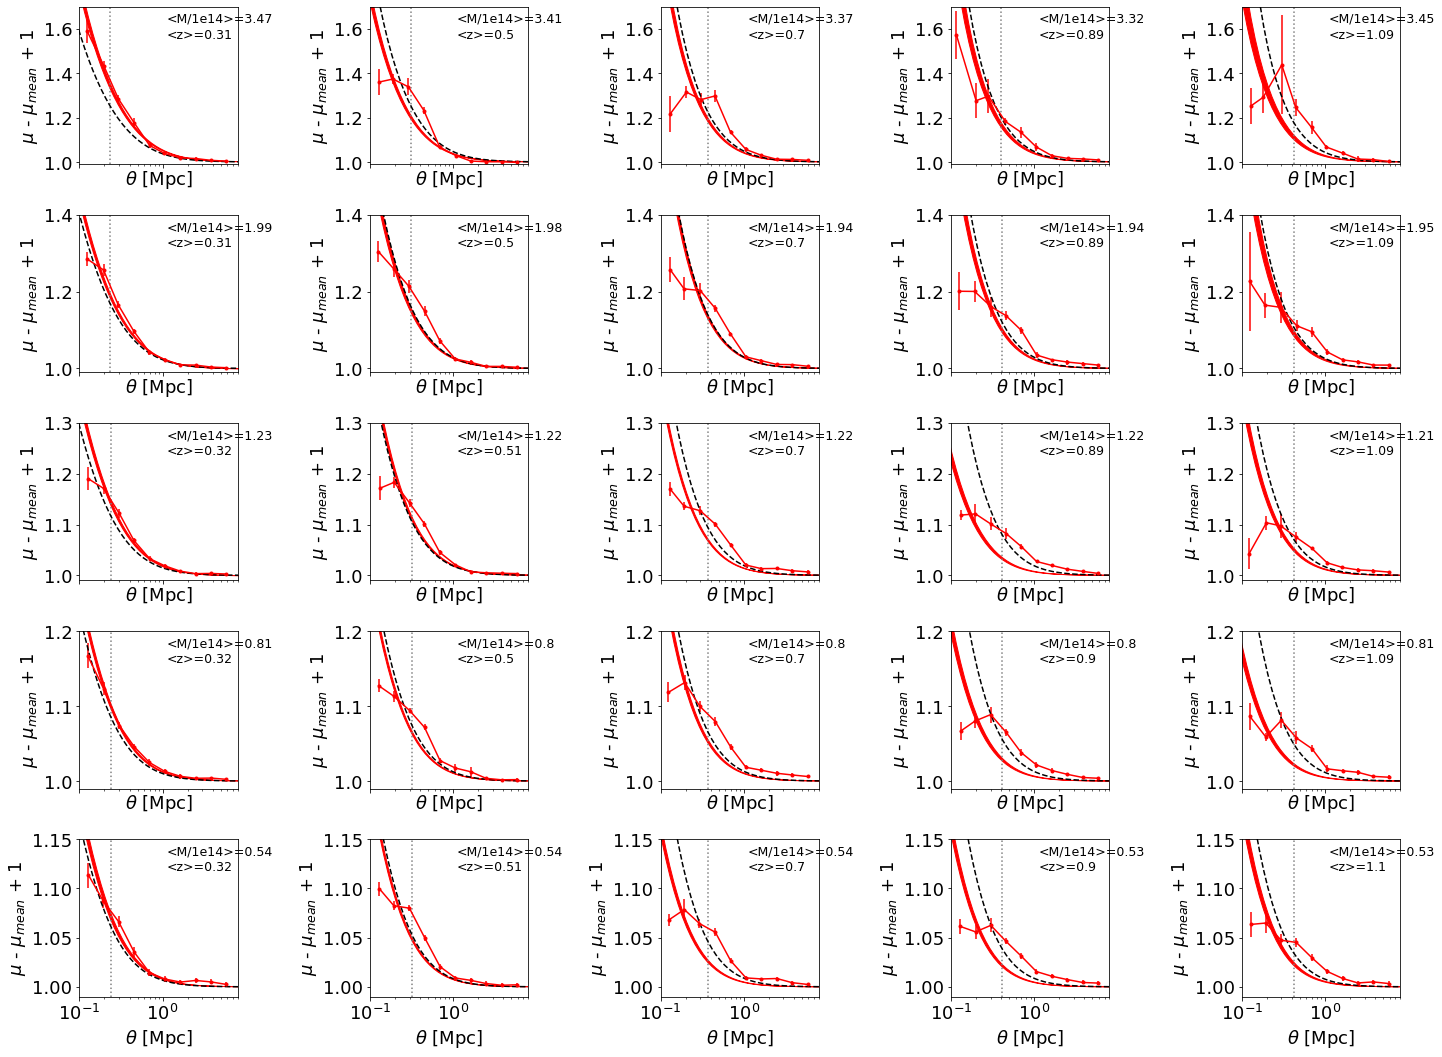

In [243]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)

corr = np.mean(gal_cat['magnification']) - 1

for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        ax = axes[5-1-k,h]
        
        #ax.fill_between(quant_NK[i,j][0], y1= quant_NK[i,j][1] - corr - np.sqrt(np.diag(quant_NK[i,j][2])),\
        #         y2 =  quant_NK[i,j][1] - corr + np.sqrt(np.diag(quant_NK[i,j][2])),color = 'blue', alpha=0.4)

        ax.errorbar(quant_NK[i,j][0],quant_NK[i,j][1] - corr ,yerr=np.sqrt(np.diag(quant_NK[i,j][2])),fmt='r.-')
        #ax.errorbar(mu_profiles[i,j][0], mu_profiles[i,j][1] - corr, yerr=mu_profiles[i,j][2], fmt='rx')


        ax.axvline(cosmo.kpc_proper_per_arcmin(z_cl[i,j]).to(u.Mpc/u.arcmin).value * healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey', label ='healpix resol.')

        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
          
        ax.set_xlabel('$\\theta$ [Mpc]')
        ax.set_ylabel('$\mu$ - $\mu_{mean}$ + 1')

        ax.plot(rp_Mpc, model_magnification[:,i,j],'k--')
        
        ax.fill_between(rp_Mpc, y1 = model_for_fitted_mass_min[i,j], y2 = model_for_fitted_mass_max[i,j],color='red')
        
plt.tight_layout()


axes[0,0].set_xscale('log')
axes[0,0].set_xlim(0.1,8)

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(0.99,1.15)
    axes[3,i].set_ylim(0.99,1.2)
    axes[2,i].set_ylim(0.99,1.3)
    axes[1,i].set_ylim(0.99,1.4)
    axes[0,i].set_ylim(0.99,1.7)